In [21]:
import torch
from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import pandas as pd
from torchmetrics import Accuracy
import numpy as np

torch.__version__

'2.0.0'

In [22]:
# If possible set using device to GPU otherwise use CPU
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [23]:
NUM_SAMPLES = 1000
RANDOM_SEED = 42

# Make example dataset
X, y = make_moons(n_samples = NUM_SAMPLES,
                  random_state = RANDOM_SEED,
                  noise = 0.07)


print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print("------------------")
print(f"Type of X: {type(X)}")
print(f"Type of X: {type(y)}")

Shape of X: (1000, 2)
Shape of y: (1000,)
------------------
Type of X: <class 'numpy.ndarray'>
Type of X: <class 'numpy.ndarray'>


In [24]:
data_df = pd.DataFrame({"x0": X[:, 0],
                     "x1": X[:, 1],
                     "y": y})
data_df.head()

,x0,x1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


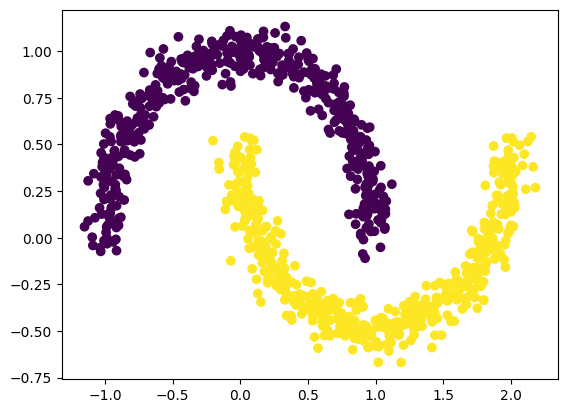

In [25]:
# Visualize data
import matplotlib.pyplot as plt

plt.scatter(data_df.x0, data_df.x1, c=data_df.y)
plt.show()

# Calculate the mean

In [26]:
# Data transform into PyTorch tensors
import torch
from sklearn.model_selection import train_test_split
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [27]:
# Creating model
class MoonModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
       
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out
    

In [28]:
# Create instance of the model
model = MoonModel(input_size=2, hidden_size=10, output_size=1).to(device)
model

MoonModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [29]:
# state dict is a dictionary that contains all weights and biases
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='mps:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='mps:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0

In [30]:
# Define functions for training
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [31]:
# Raw input of the model (logits)
print("Logits")
print(model(X_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model(X_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model(X_train.to(device)[:10]).squeeze())))

Logits
tensor([0.0019, 0.0094, 0.0161, 0.0185, 0.0284, 0.0192, 0.0291, 0.0196, 0.0258,
        0.0079], device='mps:0', grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5005, 0.5024, 0.5040, 0.5046, 0.5071, 0.5048, 0.5073, 0.5049, 0.5065,
        0.5020], device='mps:0', grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='mps:0',
       grad_fn=<RoundBackward0>)


In [32]:
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)
acc_fn

MulticlassAccuracy()

In [33]:
torch.manual_seed(RANDOM_SEED)

epochs=2000

# Send data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# loop thru the data
for epoch in range(epochs):
    # set model to training mode
    model.train()
    
    # forward pass
    y_logits = model(X_train).squeeze()
    y_pred_prob = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_prob)
    
    # Compute loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train.int())
    
    # Reset gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # test model
    model.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # Compute loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test.int())
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")
        

Epoch: 0 | Loss: 0.70 Acc: 0.37 | Test loss: 0.69 Test acc: 0.49
Epoch: 100 | Loss: 0.39 Acc: 0.82 | Test loss: 0.40 Test acc: 0.76
Epoch: 200 | Loss: 0.24 Acc: 0.88 | Test loss: 0.24 Test acc: 0.89
Epoch: 300 | Loss: 0.20 Acc: 0.91 | Test loss: 0.19 Test acc: 0.94
Epoch: 400 | Loss: 0.17 Acc: 0.93 | Test loss: 0.15 Test acc: 0.94
Epoch: 500 | Loss: 0.12 Acc: 0.95 | Test loss: 0.11 Test acc: 0.96
Epoch: 600 | Loss: 0.08 Acc: 0.98 | Test loss: 0.07 Test acc: 0.98
Epoch: 700 | Loss: 0.06 Acc: 0.99 | Test loss: 0.05 Test acc: 1.00
Epoch: 800 | Loss: 0.04 Acc: 0.99 | Test loss: 0.03 Test acc: 1.00
Epoch: 900 | Loss: 0.03 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 1000 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 1100 | Loss: 0.02 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 1200 | Loss: 0.02 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 1300 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 1400 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test ac

In [34]:



def plot_decision_boundary(model, X, y):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
     

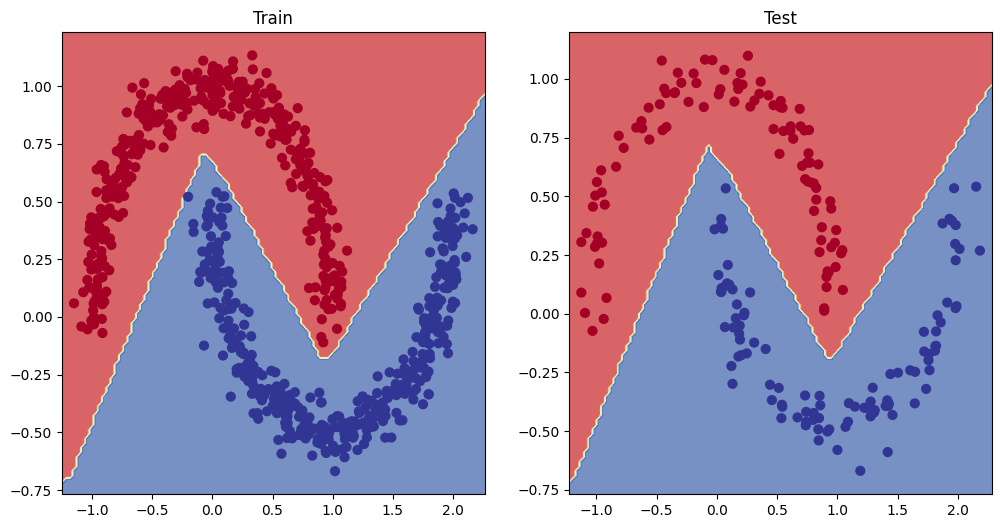

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)